<a href="https://colab.research.google.com/github/robabsmith/CALDISS-SDS-PhD-school/blob/master/Day_04_Portfolio_Part_2_Trump_tweet_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Day 4 Portfolio from afternoon

## Trump tweet predictor model

Exercise from class

In [0]:
import re

In [0]:
text =  "I’ve been called many things in my life, but never an optimist. That was fine by me. I believed pessimists lived in a constant state of pleasant surprise: if you always expected the worst, things generally turned out better than you imagined. The only real problem with pessimism, I figured, was that too much of it could accidentally turn you into an optimist."

In [0]:
import nltk #this part is needed on colab.
nltk.download('punkt')
nltk.download('stopwords')
#----------------------------------------

# Tokenizing sentences
from nltk.tokenize import sent_tokenize

# Tokenizing words
from nltk.tokenize import word_tokenize

import pandas as pd
pd.set_option('display.max_colwidth', -1) #to see more text

import numpy as np
import seaborn as sns
import itertools
from collections import Counter


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
# Tokenizing Tweets made easy!
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english')) 

In [0]:
import spacy
nlp = spacy.load("en")

In [0]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
!pip install -qq -U gensim

In [0]:
# Import the dictionary builder
from gensim.corpora.dictionary import Dictionary

In [0]:
# Import the TfidfModel from Gensim
from gensim.models.tfidfmodel import TfidfModel

In [0]:
# Just like before, we import the model
from gensim.models.lsimodel import LsiModel

In [0]:
trump_tweet_data = pd.read_csv('https://raw.githubusercontent.com/DeepLearnI/trump_tweet_classifier/master/code/tweet_labels.csv')

In [0]:
len(trump_tweet_data)

15348

### Then clean the data

In [0]:
!pip install tweet-preprocessor
import preprocessor as p

In [0]:
p.set_options(p.OPT.URL, 	p.OPT.HASHTAG, p.OPT.EMOJI, p.OPT.MENTION, 	p.OPT.RESERVED, 	p.OPT.SMILEY, 	p.OPT.NUMBER)

In [0]:
trump_tweets_clean = trump_tweet_data['tweet'].map(p.clean)

In [0]:
trump_tweets_clean = trump_tweets_clean.map(lambda t: [tok.lower() for tok in word_tokenize(t) if tok not in stop_words and tok.isalpha()])

In [0]:
trump_tweets_clean = trump_tweets_clean.map(lambda t:  " ".join(t))

## Create tokens using the Spacy package

In [0]:
tokens = []

for x in nlp.pipe(trump_tweets_clean):
  proj_tok = [token.lemma_.lower() for token in x if token.pos_ in ['NOUN', 'PROPN', 'ADJ', 'ADV'] and not token.is_stop] 
  tokens.append(proj_tok)

In [0]:
trump_tweet_data['tokens'] = tokens

In [0]:
# trump_tweet_data.head()

In [0]:
from sklearn.model_selection import train_test_split

train_tokens, test_tokens, y_train, y_test = train_test_split(tokens, trump_tweet_data.labels, test_size = 0.2)

#X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_enc, test_size = 0.2, random_state = 42)

## Create dictionary on the tokenized data


In [0]:
# Import the dictionary builder
from gensim.corpora.dictionary import Dictionary

In [0]:
# Generate a dictionary
dictionary = Dictionary(train_tokens)

In [0]:
# Filter it for extreme stuff
dictionary.filter_extremes(no_below = 10, no_above=0.4)

In [0]:
# construct corpus using this dictionary
train_corpus = [dictionary.doc2bow(doc) for doc in train_tokens]
test_corpus = [dictionary.doc2bow(doc) for doc in test_tokens]

# Use the corpus to build a model

In [0]:
# Tooling to map between corpus (gensim) and matrix - more general
from gensim.matutils import corpus2csc, corpus2dense

In [0]:

X_train = corpus2csc(train_corpus)
X_test = corpus2csc(test_corpus)

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train.T, y_train)

model.score(X_test.T, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6615635179153094

# Attempt with the TfidfModel model

In [0]:
# Create and fit a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(train_corpus)

In [0]:
train_corpus_tfidf = tfidf[train_corpus]
test_corpus_tfidf = tfidf[test_corpus]

In [0]:
X_train = corpus2csc(train_corpus_tfidf)
X_test = corpus2csc(test_corpus_tfidf)

In [0]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()

model.fit(X_train.T, y_train)

model.score(X_test.T, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.6726384364820847

# Application of LSI to the trump tweets

In [0]:
# Import the TfidfModel from Gensim
from gensim.models.tfidfmodel import TfidfModel

In [0]:
# Create and fit a new TfidfModel using the corpus: tfidf
tfidf = TfidfModel(train_corpus)

In [0]:
# Now we can transform the whole corpus
tfidf_corpus = tfidf[train_corpus]

In [0]:
 tfidf_corpus[1:10]


#### Latent semantic indexing

This is essentially singular value decomposition

In [0]:
# Just like before, we import the model
from gensim.models.lsimodel import LsiModel

# And we fir it on the tfidf_corpus pointing to the dictionary as reference and the number of topics.
# In more serious settings one would pick between 300-400
lsi = LsiModel(train_corpus, id2word=dictionary, num_topics=100)

In [0]:
lsi.show_topics(num_topics=10)

In [0]:
# And just as before, we can use the trained model to transform the corpus
lsi_corpus = lsi[train_corpus]

In [0]:
# Load the MatrixSimilarity
from gensim.similarities import MatrixSimilarity

# Create the document-topic-matrix
document_topic_matrix = MatrixSimilarity(lsi_corpus)
document_topic_matrix_ix = document_topic_matrix.index

In [0]:
# this now allows us to perform similarity-queries

sims = document_topic_matrix[lsi_corpus[0]]
sims = sorted(enumerate(sims), key=lambda item: -item[1])
print(sims)

[(0, 1.0), (127, 1.0), (191, 1.0), (233, 1.0), (257, 1.0), (387, 1.0), (601, 1.0), (636, 1.0), (645, 1.0), (951, 1.0), (1170, 1.0), (2311, 1.0), (3132, 1.0), (3464, 1.0), (3567, 1.0), (3692, 1.0), (3849, 1.0), (4773, 1.0), (4813, 1.0), (4827, 1.0), (5771, 1.0), (6204, 1.0), (6513, 1.0), (6534, 1.0), (6736, 1.0), (6837, 1.0), (7470, 1.0), (8041, 1.0), (8173, 1.0), (9237, 1.0), (9563, 1.0), (9816, 1.0), (10538, 1.0), (10569, 1.0), (10842, 1.0), (10877, 1.0), (11064, 1.0), (11093, 1.0), (11310, 1.0), (11553, 1.0), (11913, 1.0), (11932, 1.0), (11960, 1.0), (12055, 1.0), (12118, 1.0), (2967, 0.99989516), (5258, 0.9998583), (4357, 0.9998419), (1175, 0.99963707), (10223, 0.99814993), (8365, 0.99647754), (6312, 0.99638736), (4631, 0.99384725), (11597, 0.9937497), (1888, 0.9931674), (10811, 0.99191815), (4017, 0.9914786), (8740, 0.9912425), (10133, 0.98623645), (11113, 0.98266363), (11864, 0.969411), (11731, 0.9671286), (15, 0.9634267), (6416, 0.9600166), (8472, 0.9576046), (1006, 0.94750226), 

## Plot the relational distance bewteen topics / clusters

In [0]:
# dimensionalility reduction for plotting
import umap
embeddings = umap.UMAP(n_neighbors=15, metric='cosine').fit_transform(document_topic_matrix_ix)



/usr/local/lib/python3.6/dist-packages/umap/spectral.py:229: UserWarning: Embedding a total of 3 separate connected components using meta-embedding (experimental)
  n_components


In [0]:
# Nothing new here
from sklearn.cluster import KMeans
clusterer = KMeans(n_clusters = 10)
clusterer.fit(document_topic_matrix_ix)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=10, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt

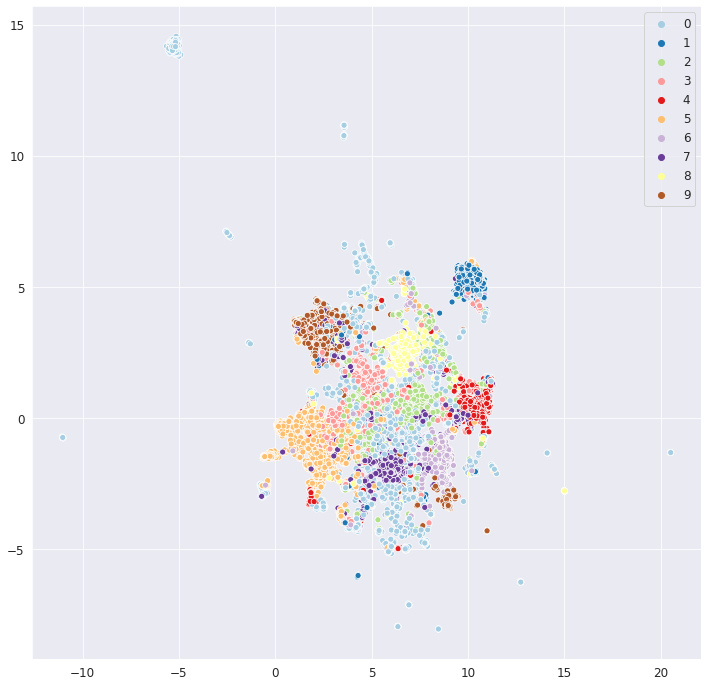

In [0]:
# Plotting things
sns.set_style("darkgrid")

plt.rcParams.update({'font.size': 12})
plt.figure(figsize=(12,12))
g = sns.scatterplot(*embeddings.T,
                    #reduced[:,0],reduced[:,1],
                   hue=clusterer.labels_,
                    palette="Paired",
                   legend='full')

# Testing for trump tweet authenticity

1. Split the original cleaned tweet dataset, including cleaned tweets and tokens.

2. Use the cleaned and uncleaned tweets to test for greater efficacy in discerning between tweets.

In [0]:
fake_test_tweet = "Keep america great agian, only a republican for president. Democrats and republicans must agree!"
arbitrary_test_tweet = "Gummy berry juice is delicious, but the power of the Gummy bears doesn't come from their juice, but from their caring! And their bouncing here and everywhere... like they are tripping out on some weird berries."

In [0]:
trump_tweet_data["clean_tweets"] = trump_tweets_clean

In [0]:
trump_tweet_data_short = pd.DataFrame(trump_tweet_data)


In [0]:
trump_tweet_data_short.reset_index()


In [0]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(trump_tweet_data_short, test_size = 0.2)

In [0]:
len(test_df)

3070

In [0]:
len(train_df)

12278

In [0]:
#train_df.head()

,tweet,labels,tokens,clean_tweets
4823,"Get the vote out in California today for Rep. Kevin McCarthy and all of the great GOP candidates for Congress. Keep our country out of the hands of High Tax, High Crime Nancy Pelosi.",True,"[vote, california, today, mccarthy, great, gop, candidate, congress, country, hand, high, tax, high, crime, nancy, pelosi]",get vote california today kevin mccarthy great gop candidates congress keep country hands high tax high crime nancy pelosi
3382,"Many Gang Members and some very bad people are mixed into the Caravan heading to our Southern Border. Please go back, you will not be admitted into the United States unless you go through the legal process. This is an invasion of our Country and our Military is waiting for you!",True,"[gang, member, bad, people, caravan, southern, border, united, state, legal, process, invasion, country, military, waiting]",many gang members bad people mixed caravan heading southern border please go back admitted united states unless go legal process this invasion country military waiting
400,"The Fake News Media is doing everything they can to crash the economy because they think that will be bad for me and my re-election. The problem they have is that the economy is way too strong and we will soon be winning big on Trade, and everyone knows that, including China!",True,"[fake, news, medium, crash, economy, bad, problem, economy, way, strong, soon, big, trade, china]",the fake news media everything crash economy think bad the problem economy way strong soon winning big trade everyone knows including china
1651,"Tariffs will bring in FAR MORE wealth to our Country than even a phenomenal deal of the traditional kind. Also, much easier & quicker to do. Our Farmers will do better, faster, and starving nations can now be helped. Waivers on some products will be granted, or go to new source!",True,"[tariff, far, wealth, country, phenomenal, deal, traditional, kind, easy, quicker, farmer, better, faster, nation, waiver, product, new, source]",tariffs bring far more wealth country even phenomenal deal traditional kind also much easier quicker our farmers better faster starving nations helped waivers products granted go new source
9222,"“I agree with Rob Portman that the Democrats were unwilling participants in the Illegal Schellas Scheme. Our vetting procedures were totally broken.” Dana Perino, U.S. Secretary of Labor. I agree with Judge @PeteStauber. We need a real HealthCare Bill - like the Great State!",False,"[rob, portman, democrat, unwilling, participant, illegal, schella, vetting, procedure, totally, perino, secretary, labor, real, healthcare, bill, great, state]",i agree rob portman democrats unwilling participants illegal schellas scheme our vetting procedures totally dana perino secretary labor i agree judge we need real healthcare bill like great state


In [0]:
#test_df.head()
#len(test_df)

,tweet,labels,tokens,clean_tweets
6347,"...people not interviewed, including Clinton herself. Comey stated under oath that he didn't do this-obviously a fix? Where is Justice Dept?",True,"[people, clinton, comey, oath, fix, justice, dept]",people interviewed including clinton comey stated oath fix where justice dept
11470,#WeAreTrump #MAGICALLYHAPPY,False,[],
7266,"Despite so many false statements and lies, total and complete vindication...and WOW, Comey is a leaker!",True,"[false, statement, complete, vindication, comey, leaker]",despite many false statements lies total complete vindication wow comey leaker
11066,"Iran never made or sent a weapon of any kind. Now that the Jus party has officially won the Election, we should look for new trade deals. We have great potential, but unfortunately for Iran, some very bad trade deals are now being negotiated (unfortunately for the U.S.).....",False,"[iran, weapon, kind, jus, party, officially, election, new, trade, deal, great, potential, unfortunately, iran, bad, trade, deal, unfortunately]",iran never made sent weapon kind now jus party officially election look new trade deals we great potential unfortunately iran bad trade deals negotiated unfortunately
2984,"Just did an interview with @HARRISFAULKNER on @FoxNews, airing now (1pmE.) Enjoy!",True,[airing],just interview airing enjoy


In [0]:
!pip install -qq -U gensim

!pip -q install eli5

In [0]:
# Import the dictionary builder
from gensim.corpora.dictionary import Dictionary

In [0]:
# Import stopwords

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [0]:
# Generate a dictionary
dictionary = Dictionary(train_df['tokens'])

In [0]:
# Filter it for extreme stuff
dictionary.filter_extremes(no_below = 10, no_above=0.4)

In [0]:
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

from gensim.sklearn_api import LsiTransformer, Text2BowTransformer, TfIdfTransformer
import numpy as np

# Create stages for our pipeline (including gensim and sklearn models alike).
bow = Text2BowTransformer(prune_at = 8000)
tfidf = TfIdfTransformer(dictionary=dictionary) # Here you can add a custom fancy tokenizer in which you define more preprocessing...
model = LsiTransformer(num_topics=200)
clf = XGBClassifier()
pipe = Pipeline([('BOW', bow), ('TFIDF', tfidf), ('features', model), ('classifier', clf)])

In [0]:
# How well does our pipeline perform on the training set?

# Here the value for "tweet", can be changed to "cleaned_tweets". This, however results in a decrease in performance.
score = pipe.fit(train_df['tweet'][:10000], train_df['labels'][:10000]).score(test_df['tweet'][:3000], test_df['labels'][:3000])

In [0]:
score

0.682

In [0]:
doc = fake_test_tweet
# doc = arbitrary_test_tweet
# doc = test_df['tweet'][6347]
print(doc)

Keep america great agian, only a republican for president. Democrats and republicans must agree!


In [0]:
import eli5
from eli5.lime import TextExplainer

te = TextExplainer(random_state=42)
te.fit(doc, pipe.predict_proba)
te.show_prediction()

## The results

The model is pretty poor at evaluating the test tweet that is intended to sound like Trump, but the arbitrary tweet performs as expected, with both a very low positive and negative contribution to the score.

Unfortunately, the actual tweet from the test set performs even worse than the fake tweet. So I'm not sure this setup is opf much use as I have put it together! 